In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Akmal
[nltk_data]     Nazim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
# Describe the data
df.describe()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


(47692, 2)

In [4]:
# Checking the missing data
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [5]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [7]:
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [8]:
df.drop_duplicates('tweet_clean', inplace=True)

In [9]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7919
age                    7815
ethnicity              7412
gender                 7288
not_cyberbullying      6084
other_cyberbullying    4933
Name: count, dtype: int64

In [10]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [11]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['tweet_clean']).toarray()
y = labelsEncoded

In [12]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((33160, 5000), (33160,), (8291, 5000), (8291,))


In [13]:
# Define the model
model = xgb.XGBClassifier(n_estimators=100, random_state=42)

In [14]:
# Implement K-Fold Cross-Validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Perform cross-validation and print results
accuracy_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {accuracy_scores}")
print(f"Mean Accuracy: {accuracy_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.84891435 0.85675513 0.85585042 0.85539807 0.85389023]
Mean Accuracy: 0.8542


In [16]:
# Train the model on the entire training set
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
# Evaluate the model on the test set
y_test_preds = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_preds)
test_report = classification_report(y_test, y_test_preds, target_names=labEncoder.classes_)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(test_report)

Test Accuracy: 0.8543
                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1529
          ethnicity       0.99      0.98      0.99      1487
             gender       0.92      0.84      0.88      1450
  not_cyberbullying       0.58      0.69      0.63      1257
other_cyberbullying       0.58      0.55      0.57       978
           religion       0.96      0.95      0.96      1590

           accuracy                           0.85      8291
          macro avg       0.84      0.83      0.83      8291
       weighted avg       0.86      0.85      0.86      8291



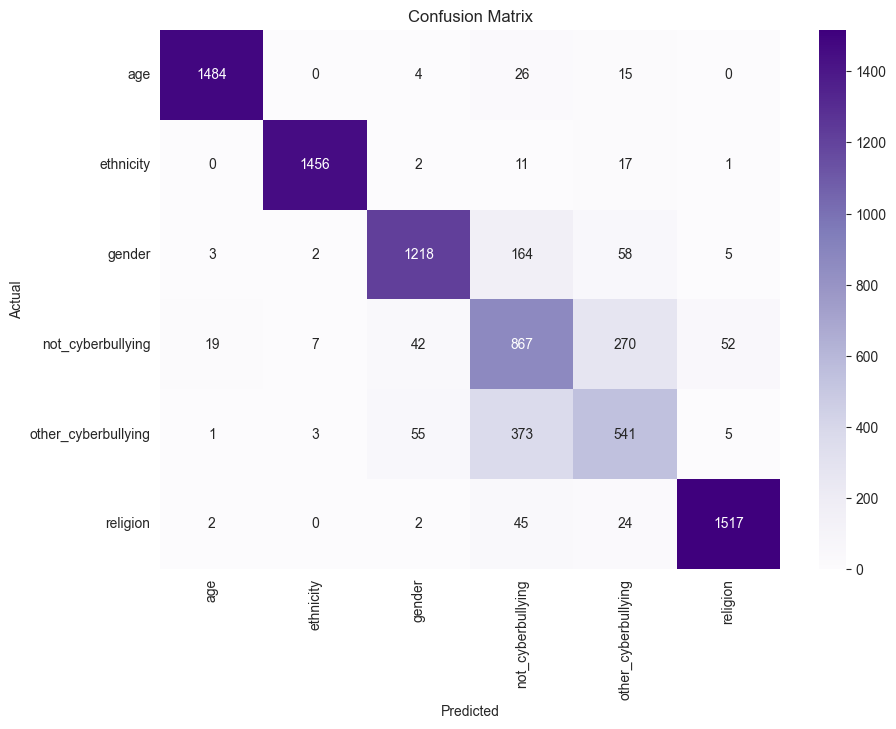

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
def predict_class(text, model, vectorizer, classes):
    vectorized_text = vectorizer.transform([text]).toarray()
    prediction = model.predict(vectorized_text)
    return classes[prediction[0]]

In [20]:
for _ in range(10):
    random_idx = np.random.randint(len(X_test))
    text, label = df['tweet_text'].iloc[random_idx], labEncoder.classes_[y_test[random_idx]]
    prediction = predict_class(text, model, vectorizer, classes=labEncoder.classes_)
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print("=============================================")

Text:
why do men find it funny when other men call women bitches and females and “joke” about how we don’t deserve any rights but the moment a woman says men are trash they’re all in the replies like “that’s so unnecessary” lmao pls just keep scrolling
Actual: not_cyberbullying	Predicted: gender
Text:
These bitches couldn't even model socks in the Best &amp; Less catalogue #mkr
Actual: ethnicity	Predicted: gender
Text:
why are men such rape apologists lmfao they'll be like "rape jokes r okay they're funny" but then get all triggered at gay men
Actual: religion	Predicted: gender
Text:
Niggas be like “females this, females that” like.. just call me a bitch so we can fight
Actual: gender	Predicted: gender
Text:
@BDSSupporter Did you just get that brain out of a cracker jacks box? http://t.co/kRaFx37dXb
Actual: religion	Predicted: not_cyberbullying
Text:
@e_killahh I can multitask when it comes to worry.
Actual: gender	Predicted: not_cyberbullying
Text:
Hopefully this will begin to die dow